In [1]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns

import importlib
# reload modules & set fname
importlib.reload(icrms)
importlib.reload(lcmsfns)


dir='/Volumes/Samsung_T5/NHMFL/2023_January_Christian/mzwindow/Zorbax_5um_inject_1500ms'
flist=os.listdir(dir)
os.chdir(dir)

fname = 'all_CHONCuFe.csv'


In [2]:
# get files & parsers

MSfiles={}

for f in flist:
    if ('.raw' in f) & ('._' not in f):
        parser = rawFileReader.ImportMassSpectraThermoMSFileReader(f)
        MSfiles[f]={'parser': parser}

data = icrms.lc_icr_assign(dir)

data.master_data_holder = MSfiles

data._raw_filelist = data.master_data_holder.keys()

In [ ]:
# set assignment parameters
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,3)
MSParameters.molecular_search.usedAtoms['Cu'] = (0,1)
MSParameters.molecular_search.usedAtoms['Fe'] = (0,1)
#MSParameters.molecular_search.usedAtoms['S'] = (0,1)
#MSParameters.molecular_search.usedAtoms['P'] = (0,1)




In [ ]:
# run assignment algorithm
timerange = [4,24]  # start (min) to stop (min)
interval = 2  # min 
refmasslist = "/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref"

data.assign_formula(interval = interval, timerange = timerange, refmasslist = refmasslist, calorder =2)

data_df = data.complete_results_df

In [ ]:
# save assignment results as pd dataframe and export as .csv 

data_df.to_csv(dir+'/' +fname)


In [ ]:
# add 'm/z window' and 'rep' columns
# reload modules & set fname
importlib.reload(icrms)
importlib.reload(lcmsfns)

data_df = pd.read_csv(dir+'/' +fname)
data_df = lcmsfns.add_mzwindow_col(data_df)

data_df = lcmsfns.addRepCol(data_df)

print(data_df['m/z window'].unique())
print(data_df['Rep'].unique())
print(data_df['file'].unique())
print(data_df['m/z Window Size'].unique())

In [ ]:
# add mol classes
importlib.reload(icrms)
importlib.reload(lcmsfns)

heter = ['N', 'Cu', 'Fe']
molclasses = lcmsfns.get_mol_class(heter)

data_df = lcmsfns.assign_mol_class(data_df,molclasses)


In [ ]:
# add column with blank file identity to use in blank subtraction

raw_filelist = data_df['file'].unique()

blank_files = [f for f in raw_filelist if 'qh2o' in f]

blank_data = []

for f in blank_files:

    #if 'fullmz' not in f:
        
    temp = data_df[data_df['file'] == f] 

    blank_data.append(temp)

blanks_df = pd.concat(blank_data)  # these are only 100 m/z blanks (200 m/z blanks were not collected)


print(blanks_df['file'].unique())

print(blanks_df['m/z window'].unique())


data_df['blank file'] = data_df.index

for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window
    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]

     #  print(np.shape( btemp2['file']))

        temp2['blank file'] = btemp2['file'].iloc[0]
     #   print(np.shape( btemp2['file']))
        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2




In [ ]:
# save assignment results as pd dataframe and export as .csv 
data_df.to_csv(dir+'/processed_'+fname)


In [3]:
#-#-#-# read assignment results from .csv
data_df = pd.read_csv(dir+'/processed_'+fname) ## for 1/17/23

In [4]:
# create subsets of assignments based m/z window

list100mz = []
listfullzmz = [] 

for mzwindow in data_df['m/z window'].unique():

    r_df = data_df[data_df['m/z window'] == mzwindow]

    if (mzwindow == '400-500 m/z') or (mzwindow == '500-600 m/z') or (mzwindow == '600-700 m/z') or (mzwindow == '700-800 m/z'):
        list100mz.append(r_df) 

    elif (mzwindow == '200-1200 m/z'):
        listfullzmz.append(r_df) 

mz100 = pd.concat(list100mz)
mzfull = pd.concat(listfullzmz)


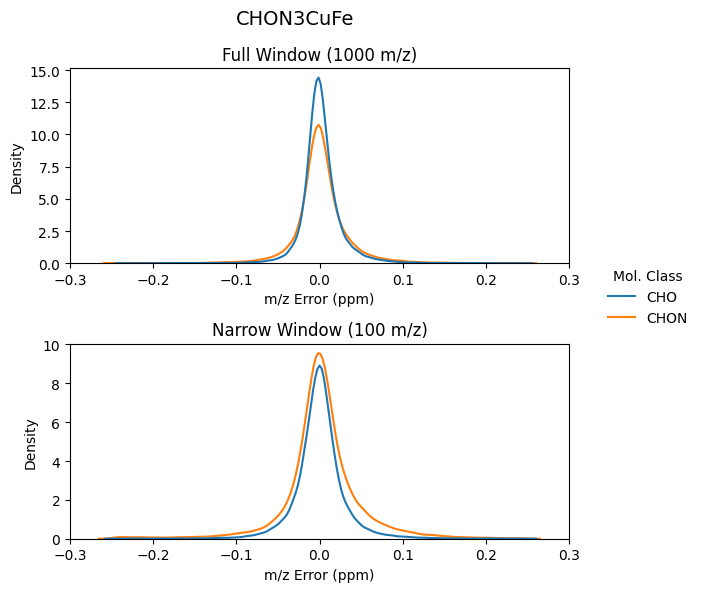

In [5]:
# plot assignment error kernel density CHON

ttt = 'CHON3CuFe'  ## title for main plot

dffull = mzfull[(mzfull['mol_class']=='CHO') | (mzfull['mol_class']=='CHON')]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax1)
ax1.set_xlim(-0.3,0.3)
ax1.set_title( 'Full Window (1000 m/z)')
legend = ax1.get_legend()
handles = legend.legendHandles
labels = dffull[dffull['mol_class']!='Unassigned']['mol_class'].unique()
legend.remove()

df100 = mz100[(mz100['mol_class']=='CHO') | (mz100['mol_class']=='CHON')]
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax2, legend = False)
ax2.set_title( 'Narrow Window (100 m/z)')
ax2.set_xlim(-0.3,0.3)


fig.suptitle(ttt, fontsize=14)
fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


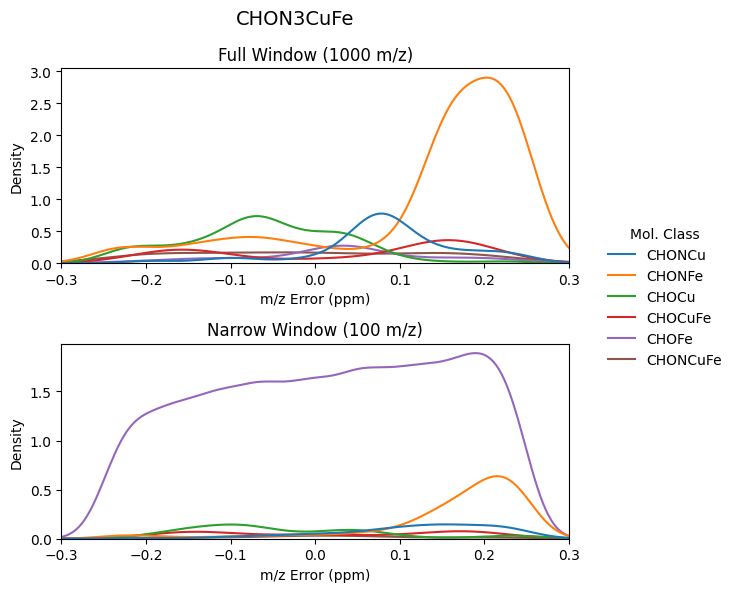

In [6]:
# plot assignment error kernel density CHON
import itertools
ttt = 'CHON3CuFe'  ## title for main plot

# set palette 
palette = itertools.cycle(sns.color_palette())

dffull = mzfull[(mzfull['mol_class']!='CHO') & (mzfull['mol_class']!='CHON')]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax1, palette=palette)
ax1.set_xlim(-0.3,0.3)
ax1.set_title( 'Full Window (1000 m/z)')
legend = ax1.get_legend()
handles = legend.legendHandles
labels = dffull[dffull['mol_class']!='Unassigned']['mol_class'].unique()
legend.remove()

palette = itertools.cycle(sns.color_palette())

df100 = mz100[(mz100['mol_class']!='CHO') & (mz100['mol_class']!='CHON')]
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax2, legend = False, palette=palette)
ax2.set_title( 'Narrow Window (100 m/z)')
ax2.set_xlim(-0.3,0.3)

fig.suptitle(ttt, fontsize=14)
fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


In [5]:
# create subsets of assigned features 
assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

print('400-700 m/z, 100 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz100)[0],  np.shape(assigned_100mz)[0], np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100))
print('\n200-800 m/z window (full scan): \n%s features total; %s assigned (%.1f%%)' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100))

400-700 m/z, 100 m/z windowing: 
190518 features total; 127837 assigned (67.1%)

200-800 m/z window (full scan): 
193791 features total; 136910 assigned (70.6%)


In [6]:
# create subsets of unique features 
print('400-700 m/z, 100 m/z windowing:')
unique_100mz = lcmsfns.getUniqueFeatures(assigned_100mz)

print('\n200-800 m/z, 1000 m/z windowing:')
unique_fullmz = lcmsfns.getUniqueFeatures(assigned_fullmz)


400-700 m/z, 100 m/z windowing:

200-800 m/z, 1000 m/z windowing:


In [9]:
# subset assigned by m/z window between 400 and 700 m/z 
assigned_100mz_456 = assigned_100mz[(assigned_100mz['m/z']>=400)]
assigned_100mz_456 = assigned_100mz_456[(assigned_100mz_456['m/z']<=700)]

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=400)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=700)]

mz100_456 = mz100[(mz100['m/z']>=400)]
mz100_456 = mz100_456[(mz100_456['m/z']<=700)]

mzfull_456 = mzfull[(mzfull['m/z']>=400)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=700)]

print('400-700 m/z, 100 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz100_456)[0],  np.shape(assigned_100mz_456)[0], np.shape(assigned_100mz_456)[0] / np.shape(mz100_456)[0] * 100))
print('\n400-700 m/z, full window: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100))


400-700 m/z, 100 m/z windowing: 
190518 features total
127837 assigned (67.1%)

400-700 m/z, full window: 
108026 features total
76351 assigned (70.7%)


In [10]:
print('400-700 m/z, 100 m/z windowing:')
unique_100mz_456 = lcmsfns.getUniqueFeatures(assigned_100mz_456)

print('\n400-700 m/z, 1000 m/z windowing:')
unique_fullmz_456 = lcmsfns.getUniqueFeatures(assigned_fullmz_456)

400-700 m/z, 100 m/z windowing:

400-700 m/z, 1000 m/z windowing:


(0.0, 1000.0)

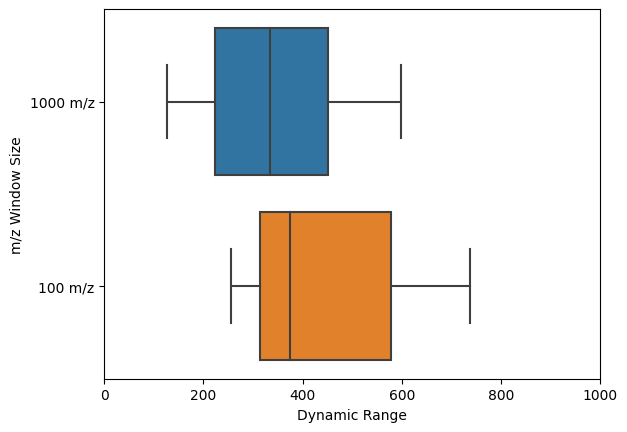

In [11]:
# plot dynamic range with box-whiskers plot

alldf = pd.concat([lcmsfns.blankSubtract(unique_fullmz_456, blnkthresh = 0.6), lcmsfns.blankSubtract(unique_100mz_456, blnkthresh = 0.6)])
alldf = pd.concat([unique_fullmz_456, unique_100mz_456])

for f in flist:
    if 'StdMix' in f:
        stdfile = f
alldf = alldf[alldf['file'] != stdfile]
times = data_df['Time'].unique()

holder = {}
summary = []
summary2 = []

for mzw in alldf['m/z Window Size'].unique():
    
    sub1 = alldf[alldf['m/z Window Size'] == mzw]

    for t in times:
        
        lsh = {}
        lsh['m/z Window Size'] = mzw

        sub2 = sub1[sub1['Time'] == t]

        sub2 = sub2[sub2['S/N'] > 3]
        
        dynamic_range_t = max(sub2['Peak Height']/min(sub2['Peak Height']))
        
        lsh['Time'] = t
        lsh['Dynamic Range'] = dynamic_range_t        
        lsh['n Features'] = len(sub2)
        lsh['Max I'] = max(sub2['Peak Height'])
        
        lsh['Min I'] = min(sub2['Peak Height'])
        summary.append(lsh)


df=pd.DataFrame(summary)

sns.boxplot(data=df, x="Dynamic Range", y="m/z Window Size")

plt.xlim(0,1000)

In [12]:
# get subsets of data for mz window comparison

mz100_bs = lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
mzfull_bs = lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6)

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=400) & (mzfull_bs['Calibrated m/z']<=600)]
combo = pd.concat([mz100_bs, mzfull_bs_456], ignore_index=True)


for i in range(len(combo['m/z window'])):

    w = combo['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'): # or (w == '600-700 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '200-1200 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '1000 m/z'

print(combo['m/z Window Size'].unique())


mzfull_456 = mzfull[(mzfull['Calibrated m/z']>=400) & (mzfull['Calibrated m/z']<=600)]
combo2 = pd.concat([mz100, mzfull_456], ignore_index=True)

for i in range(len(combo['m/z window'])):

    w = combo2['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'): # or (w == '600-700 m/z'):
        
        combo2['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '200-1200 m/z'):
        
        combo2['m/z Window Size'].iloc[i] = '1000 m/z'

print(np.shape(combo),np.shape(combo2))



['100 m/z' '1000 m/z']
(40652, 81) (290171, 42)


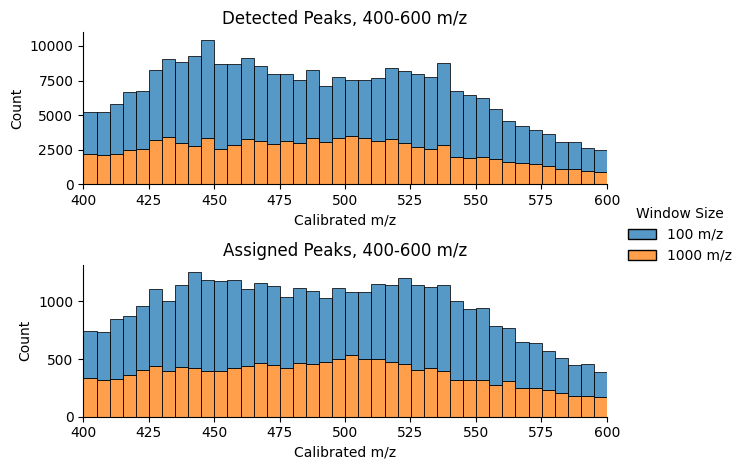

In [14]:
# plot histograms of detected and assigned features, both windows

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])


ax1 = plt.subplot(gs2[0])

sns.histplot(combo, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax1,binwidth=5)
ax1.set_ylabel('Count')
ax1.legend_.remove()
ax1.set_xlim(400,600)
ax1.set_title('Assigned Peaks, 400-600 m/z')
#ax1.set_ylim(0,4500)

sns.despine(ax=ax1)


ax2 = plt.subplot(gs1[0])

sns.despine(ax=ax2)

sns.histplot(combo2, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2,binwidth=5)
ax2.set_ylabel('Count')
ax2.set_xlim(400,600)
#ax2.set_ylim(0,4500)
ax2.set_title('Detected Peaks, 400-600 m/z')
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

fig.tight_layout()
plt.show()

['CHO' 'CHON' 'CHONFe' 'CHOCu' 'CHOCuFe' 'CHONCuFe' 'Unassigned' 'CHONCu'
 'CHOFe']


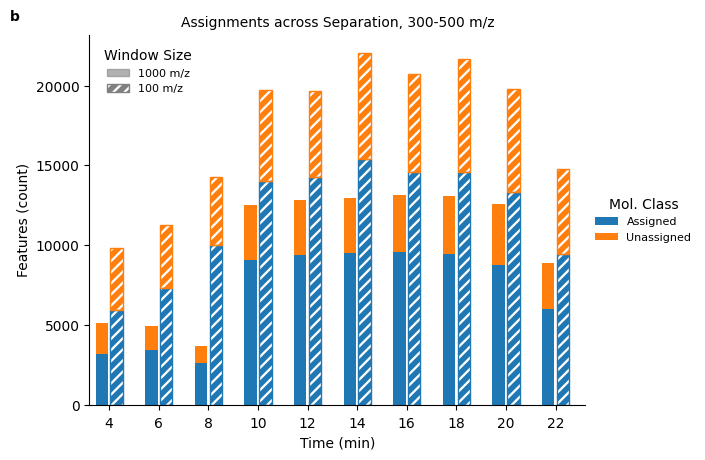

In [15]:
# plot number of assigned and unassigned features for each 2-min along chroma for both mz windows

fig, ax4 = plt.subplots()

all_results = pd.concat([mzfull[(mzfull['m/z']>=400) & (mzfull['m/z']<=600)],mz100[(mz100['m/z']>=400) & (mz100['m/z']<=600)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in all_results['mol_class'].unique():
            if mol_class == 'Unassigned':
                current['Unassigned']=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
            else:
                current['Assigned']=len(all_results[(all_results['mol_class']!='Unassigned') & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)

df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']

ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)

# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Features (count)')

leg = plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), frameon=False, title='Mol. Class', prop={'size': 8})
ax4.add_artist(leg)
ax4.set_title('Assignments across Separation, 300-500 m/z',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray', facecolor = 'white', hatch = '///',label='100 m/z')

colors = ['#EA5739','#FEFFBE','#4BB05C']

#circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'\\\\',label='Label1')
#circ2= mpatches.Patch( facecolor=colors[1],alpha=a_val,hatch='o',label='Label2')
#circ3 = mpatches.Patch(facecolor=colors[2],alpha=a_val,hatch='+',label='Label3')

plt.legend(handles=[patch_full, patch_100], loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.

sns.despine(ax=ax4)
ax4.text(-.15, 1.05,'b',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax4.transAxes, fontweight='bold', fontsize = 10)
sns.despine(ax=ax4)

plt.show()





['CHO' 'CHON' 'CHONFe' 'CHOCu' 'CHOCuFe' 'CHONCuFe' 'Unassigned' 'CHONCu'
 'CHOFe']


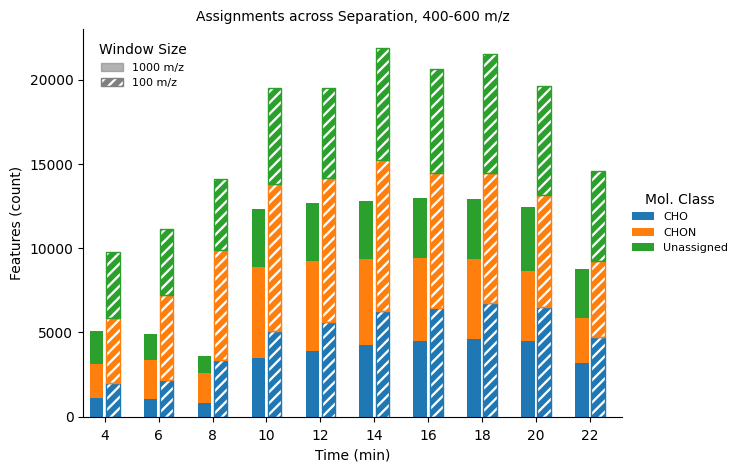

In [16]:
# plot assignments across separation
# 
fig, ax4 = plt.subplots()

all_results = pd.concat([mzfull[(mzfull['m/z']>=400) & (mzfull['m/z']<=600)],mz100[(mz100['m/z']>=400) & (mz100['m/z']<=600)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in ['CHO','CHON', 'Unassigned']:
            current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']

ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)
    ax4.patches[i+(2*n)].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)
        ax4.patches[i+(2*n)].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)
        #ax4.patches[i+(2*n)].set_alpha(0.7)
        ax4.patches[i+(2*n)].set_hatch('///')
        ax4.patches[i+(2*n)].set_edgecolor('C2')
        ax4.patches[i+(2*n)].set_fill(None)



# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Features (count)')
ax4.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, title='Mol. Class')

leg = plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), frameon=False, title='Mol. Class', prop={'size': 8})
ax4.add_artist(leg)

ax4.set_title('Assignments across Separation, 400-600 m/z',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray', facecolor = 'white', hatch = '///',label='100 m/z')



colors = ['#EA5739','#FEFFBE','#4BB05C']


#circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'\\\\',label='Label1')
#circ2= mpatches.Patch( facecolor=colors[1],alpha=a_val,hatch='o',label='Label2')
#circ3 = mpatches.Patch(facecolor=colors[2],alpha=a_val,hatch='+',label='Label3')


plt.legend(handles=[patch_full, patch_100], loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.

sns.despine(ax=ax4)
fig = plt.gcf()
fig.tight_layout(pad = 1.)
plt.show()


['CHO' 'CHON' 'CHONFe' 'CHOCu' 'CHOCuFe' 'CHOFe' 'CHONCuFe' 'Unassigned'
 'CHONCu']


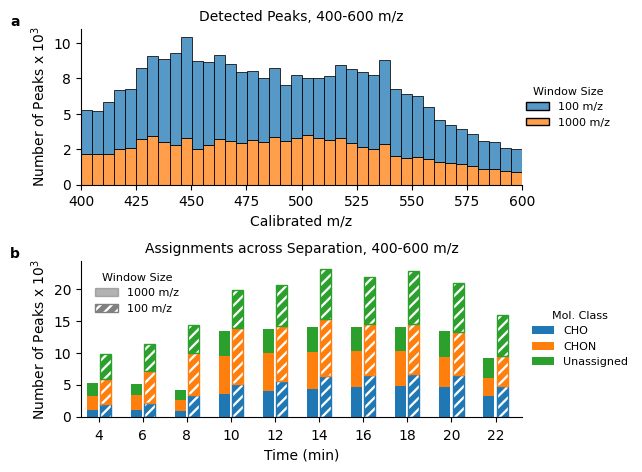

In [17]:
# histogram of features (a) and chromatogram of features (b)
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])

plt.rcParams['legend.title_fontsize'] = 8


ax2 = plt.subplot(gs1[0])

sns.despine(ax=ax2)

sns.histplot(combo2, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2,binwidth=5)
ax2.set_ylabel('Number of Peaks x $10^3$')
ax2.set_xlim(400,600)
#ax2.set_ylim(0,4500)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.set_title('Detected Peaks, 400-600 m/z', fontsize = 10)
#ax2.legend_.remove()

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
fig = plt.gcf()

ax2.legend(handles, labels, bbox_to_anchor=(1.0, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})
ax2.text(-0.15, 1.05,'a',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax2.transAxes, fontweight='bold', fontsize = 10)

ax4 = plt.subplot(gs2[0])


all_results = pd.concat([mzfull[(mzfull['m/z']>=400) & (mzfull['m/z']<=700)],mz100[(mz100['m/z']>=400) & (mz100['m/z']<=700)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in ['CHO','CHON', 'Unassigned']:
            current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']
ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)
    ax4.patches[i+(2*n)].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)
        ax4.patches[i+(2*n)].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)
        #ax4.patches[i+(2*n)].set_alpha(0.7)
        ax4.patches[i+(2*n)].set_hatch('///')
        ax4.patches[i+(2*n)].set_edgecolor('C2')
        ax4.patches[i+(2*n)].set_fill(None)



# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Number of Peaks x $10^3$')

ax4.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, title='Mol. Class')

leg = plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), frameon=False, title='Mol. Class', prop={'size': 8})
ax4.add_artist(leg)
ax4.set_title('Assignments across Separation, 400-600 m/z',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray', facecolor = 'white', hatch = '///',label='100 m/z')



colors = ['#EA5739','#FEFFBE','#4BB05C']


#circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'\\\\',label='Label1')
#circ2= mpatches.Patch( facecolor=colors[1],alpha=a_val,hatch='o',label='Label2')
#circ3 = mpatches.Patch(facecolor=colors[2],alpha=a_val,hatch='+',label='Label3')


plt.legend(handles=[patch_full, patch_100], loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.
sns.despine(ax=ax4)
ax4.text(-.15, 1.05,'b',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax4.transAxes, fontweight='bold', fontsize = 10)
fig = plt.gcf()
fig.tight_layout(pad = 1.)

plt.show()

In [14]:
fullscan = combo[combo['m/z Window Size'] == '1000 m/z']
narrowscan = combo[combo['m/z Window Size'] == '100 m/z']

narrow_only = narrowscan[~narrowscan['Molecular Formula'].isin(fullscan['Molecular Formula'])]

full_only = fullscan[~fullscan['Molecular Formula'].isin(narrowscan['Molecular Formula'])]

narrow_full = narrowscan[narrowscan['Molecular Formula'].isin(fullscan['Molecular Formula'])]

print('MFs in narrow window only: %s' %len(narrow_only))
print('MFs in full window only: %s' %len(full_only))
print('MFs in narrow and full window only: %s' %len(narrow_full))

combo_adj = combo 

combo_adj['FeatureIn'] = combo_adj.index

holder = []

naronly = narrow_only['Molecular Formula'].isin(combo_adj['Molecular Formula'])

sub = combo_adj.loc[naronly.index]

sub['FeatureIn'] = '100 m/z only'

print(len(sub))
holder.append(sub)


both = narrow_full['Molecular Formula'].isin(combo_adj['Molecular Formula'])

sub1 = combo_adj.loc[both.index]

sub1['FeatureIn'] = 'Both windows'

holder.append(sub1)

df = pd.concat(holder)

#combo_adj['FeatureIn'] = test.index

MFs in narrow window only: 6517
MFs in full window only: 282
MFs in narrow and full window only: 19093
6517


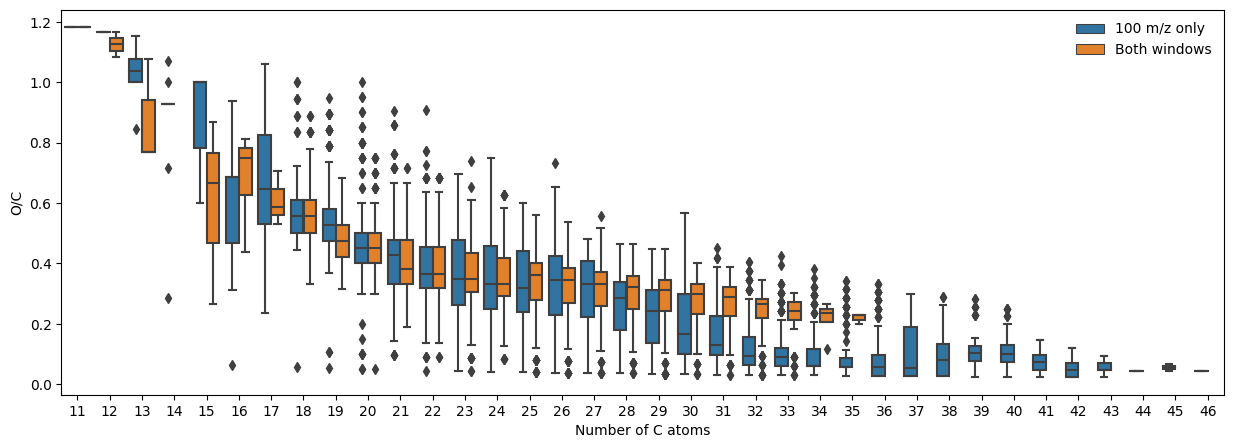

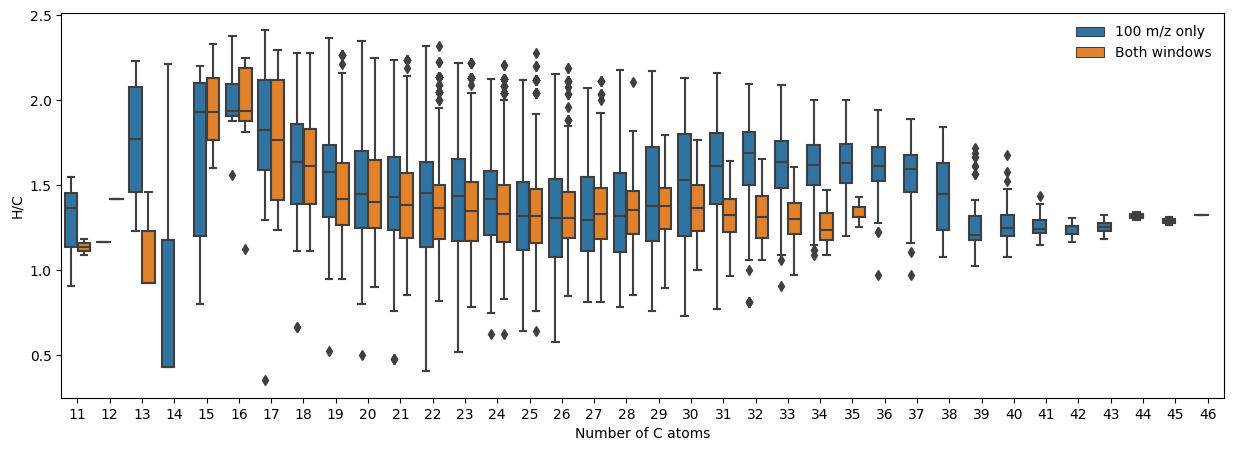

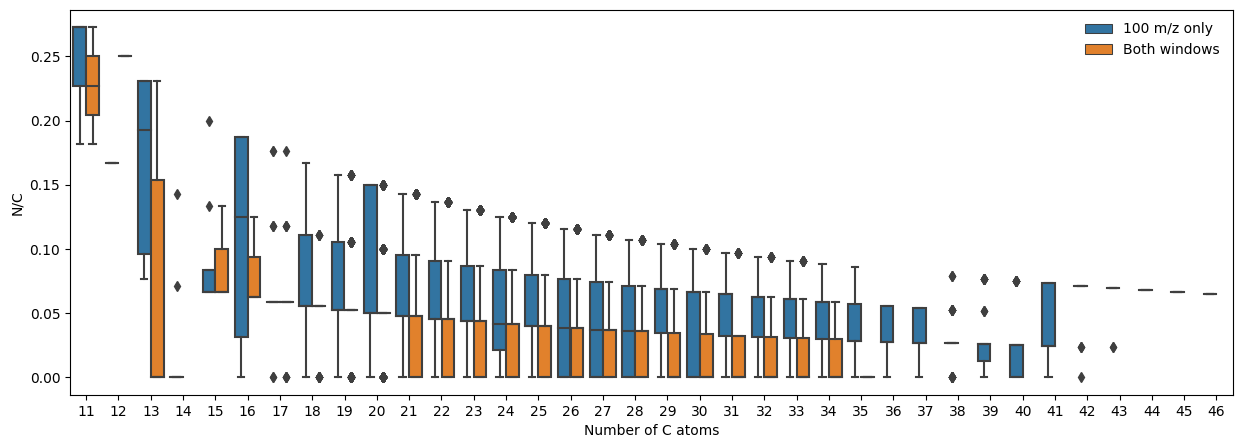

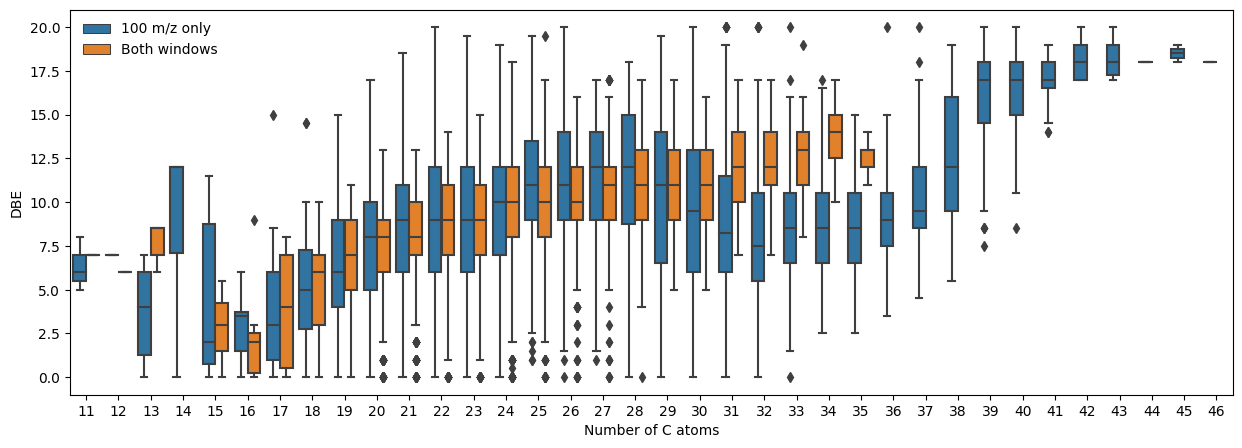

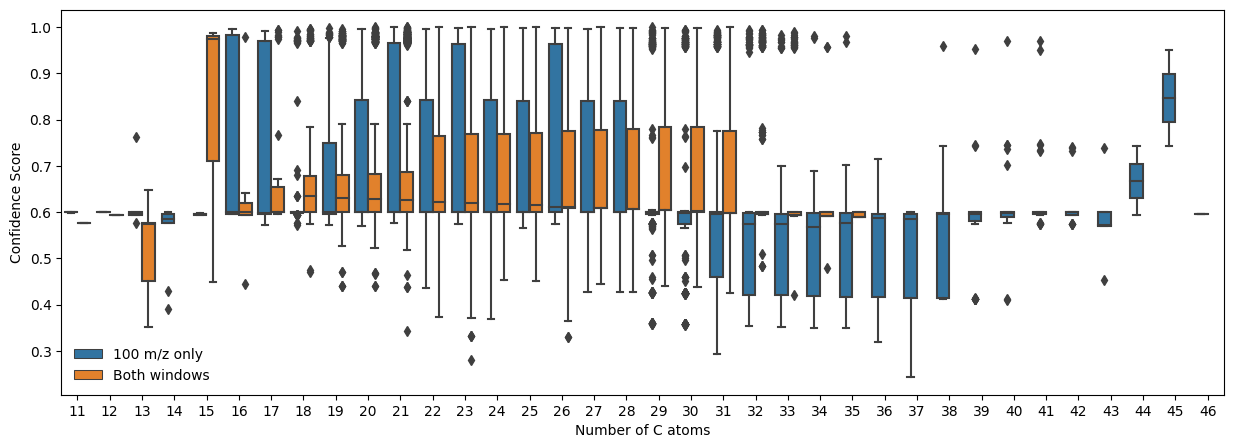

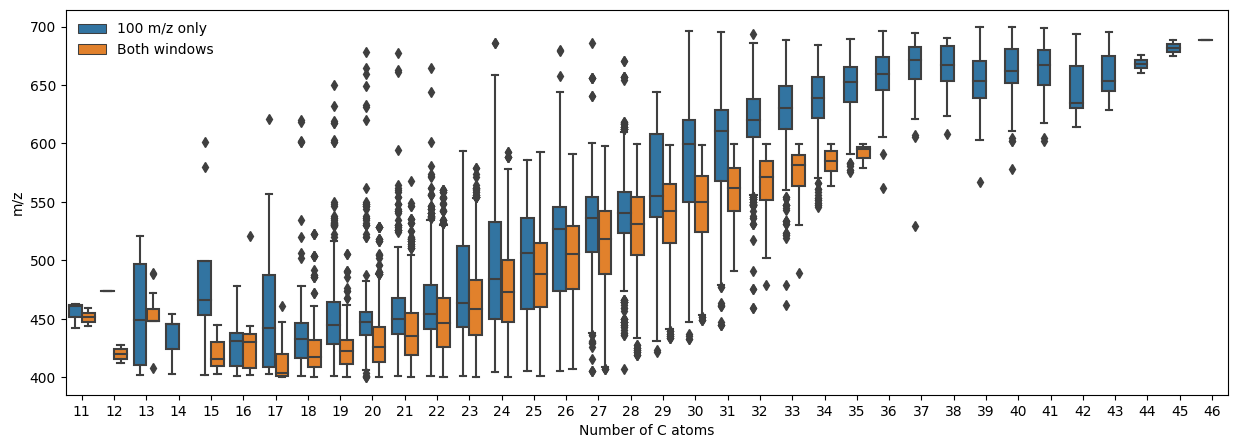

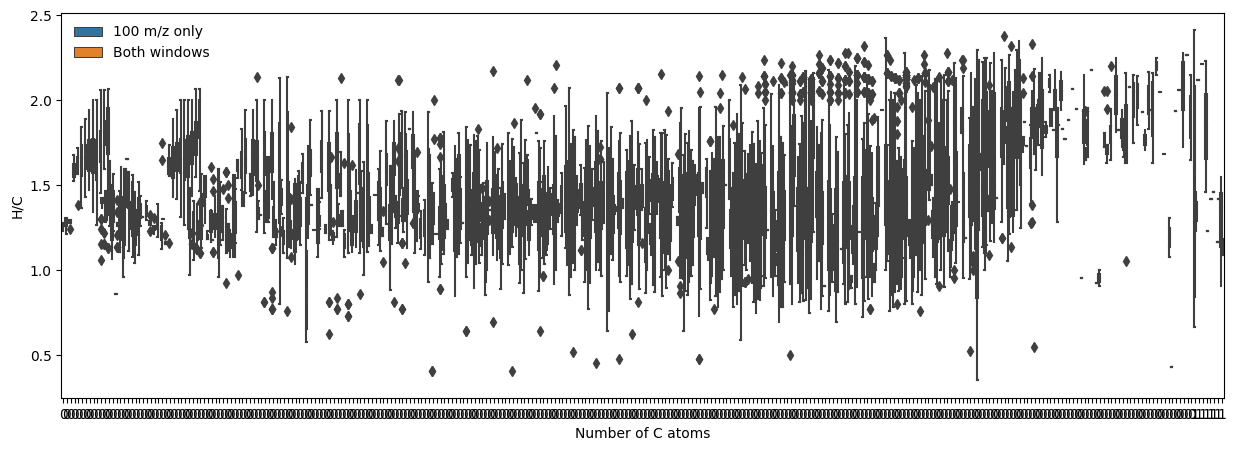

In [16]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)




fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'O/C', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()

fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'H/C', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()



fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'N/C', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()

fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'DBE', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()


fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'Confidence Score', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()


fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'm/z', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()



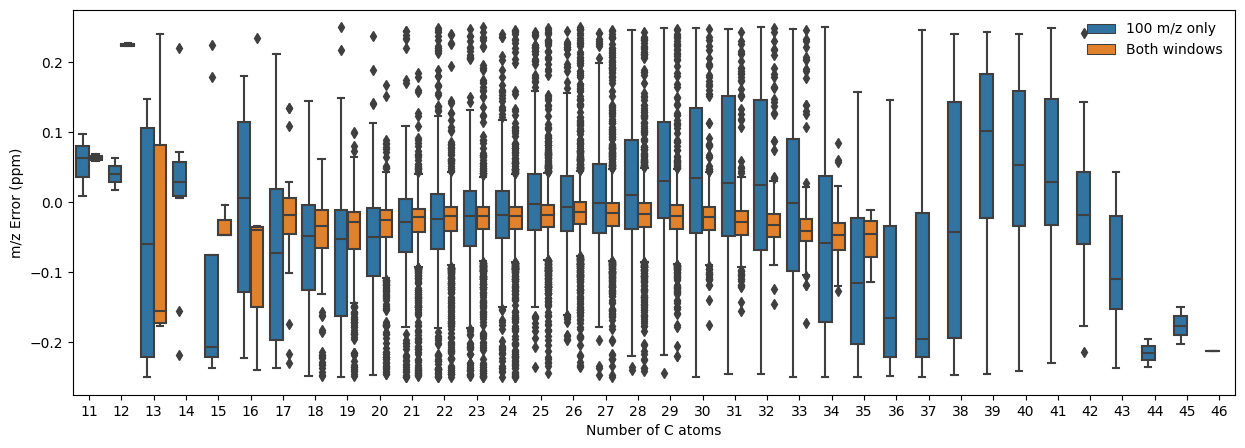

In [27]:

fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'm/z Error (ppm)', hue = 'FeatureIn',showfliers = True )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')

plt.show()

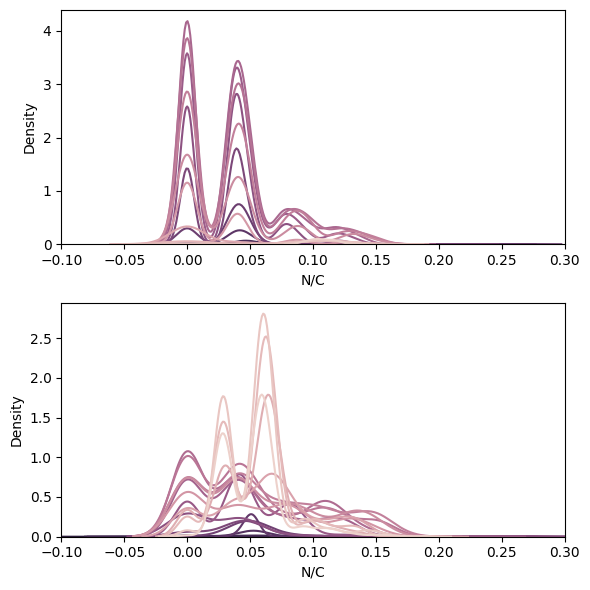

In [14]:


column = 'N/C'  ## title for main plot
column2 = 'H/C'
hue_col = 'O'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))

mzfull = narrow_full
dffull = mzfull#[(mzfull['mol_class']=='CHO') | (mzfull['mol_class']=='CHON')]
dffull.sort_values(by=['mol_class'],inplace=True)
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'],legend=False, x=column, hue=hue_col, ax = ax1)
ax1.set_xlim(-0.1,0.3)
#ax1.set_title('Confidence scores for shared features m/z\nO/C range 0-20 (dark == 20 O)')


mz100 = narrow_only
df100 = mz100#[(mz100['mol_class']=='CHO') | (mz100['mol_class']=='CHON')]
df100.sort_values(by=['mol_class'],inplace=True)
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x=column, hue=hue_col, ax = ax2, legend = False)  # for some reason, order of mol class is reverse in narrow m/z range
ax2.set_xlim(-0.1,0.3)
#ax2.set_title('Confidence scores for narrow m/z\nO/C range 0-20 (dark == 20 O)')
"""
mzfull = narrow_full
dffull = mzfull#[(mzfull['mol_class']=='CHO') | (mzfull['mol_class']=='CHON')]
dffull.sort_values(by=['mol_class'],inplace=True)
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x=column2, legend = False, hue=hue_col, ax = ax2)
#ax1.set_xlim(-0.3,0.3)


mz100 = narrow_only
df100 = mz100#[(mz100['mol_class']=='CHO') | (mz100['mol_class']=='CHON')]
df100.sort_values(by=['mol_class'],inplace=True)
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x=column2, hue=hue_col,linestyle = '--', ax = ax2, legend = False)  # for some reason, order of mol class is reverse in narrow m/z range

"""
#fig.suptitle(ttt, fontsize=14)
#fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


In [ ]:
# plot ms with cu features from both windows 

importlib.reload(icrms)
importlib.reload(lcmsfns)
import matplotlib.gridspec as gridspec



mz100_bs = lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
mzfull_bs = lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6)

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=400) & (mzfull_bs['Calibrated m/z']<=600)]
mzfull_cu= mzfull_bs_456[mzfull_bs_456['file'].str.contains('Slough_ENV')]

mz100_cu_t = mz100_bs[(mz100_bs['Calibrated m/z']>=400) & (mz100_bs['Calibrated m/z']<=600) ]
mz100_cu = mz100_cu_t[mz100_cu_t['file'].str.contains('Slough_ENV')]


In [ ]:
def getEICs(df):

    EICdic = {}
    
    for mz,cmz, mf,er,file in zip(df['m/z'],df['Calibrated m/z'],df['Molecular Formula'],df['m/z Error (ppm)'],df['file']):

        parser = data.master_data_holder[file]['parser']

        EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
        
        EICdic[mf]={'EIC_data':EIC[0][mz],'file':file, 'cal_mz':cmz,'ppm_err': er}

    return EICdic

In [ ]:
df = mz100_cu
df = df[(df['m/z']<=600)& (df['m/z']>=400)]
df = df[df['Fe']>0]
df = df[df['file'].str.contains('Slough_ENV') ]

narrowmz = getEICs(df)

df2 = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<=600)]
df2 = df2[df2['Fe']>0]
df2 = df2[df2['file'].str.contains('Slough_ENV') ]

fullmz = getEICs(df2)


In [ ]:
label = '100 m/z' #r'$\Delta$m/z 

label2 =  '1000 m/z'

from matplotlib.backends.backend_pdf import PdfPages

savefig = False

if savefig:
    pdf = PdfPages(dir+'/eics_Fe_slough_ppl_ALL.pdf')


for mf in narrowmz:   

    fig, ax = plt.subplots()
    
    eic = narrowmz[mf]['EIC_data']
    file = narrowmz[mf]['file']
    calmz = narrowmz[mf]['cal_mz']
    ppmerr = narrowmz[mf]['ppm_err']

    
    eict=eic.time
    eics=eic.eic

    inds = np.where(np.asarray(eict)<30)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=label)#
    
    move_down = False

    if mf in fullmz:

        eicf = fullmz[mf]['EIC_data']
        filef = fullmz[mf]['file']

        calmzf = narrowmz[mf]['cal_mz']
        ppmerrf = narrowmz[mf]['ppm_err']
        
        eictf=eicf.time
        eicsf=eicf.eic

        indsf = np.where(np.asarray(eictf)<30)

        eictf = np.asarray(eictf)[indsf]
        eicsf = np.asarray(eicsf)[indsf]

        ax.plot(eictf, eicsf, color = 'C0', label=label2)#
        ax.text(1.05, 0.32, 'm/z: %.5f \nerror (ppm): %.2f' %(calmzf, ppmerrf),
            color = 'C0',
            horizontalalignment='left',
            verticalalignment='center',
            transform = ax.transAxes,  fontsize = 8)
        
        move_down = True

    if move_down:
        ax.text(1.05, 0.4, 'm/z: %.5f \nerror (ppm): %.2f' %(calmz, ppmerr),
            color = 'red',
            horizontalalignment='left',
            verticalalignment='center',
            transform = ax.transAxes,  fontsize = 8)

        move_down = False
    
    else:

        ax.text(1.05, 0.42, 'm/z: %.5f \nerror (ppm): %.2f' %(calmz, ppmerr),
            color = 'red',
            horizontalalignment='left',
            verticalalignment='center',
            transform = ax.transAxes,  fontsize = 8)


    ax.set_xlim(0,30)
    ax.set_title(mf)
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left',frameon=False, borderaxespad=0,  prop={'size': 8})

    ax.set_xlabel('Time (min)')
    ax.set_ylabel("Intensity")
    sns.despine()
    fig.tight_layout()

    if savefig == False:
        plt.show()
    else:
        pdf.savefig()

if savefig:

    pdf.close()

In [ ]:
# invalids mfs for Cu
invalid_mf_cu = ['C15 H12 O15 N2 Fe1 Cu1', 
            'C26 H34 O8 Cu1',
            'C19 H38 O13 Cu1',
            'C30 H34 O2 13C1 Cu1',
            'C23 H36 O2 Fe1 Cu1',
            'C13 H12 O10 Fe1 Cu1',
            'C15 H15 O9 N1 Fe1 Cu1',
            'C27 H37 O1 N3 Fe1 Cu1',
            'C26 H48 O3 N2 Cu1',
            'C26 H35 O1 N1 Cu1']

# invalids mfs for Fe
invalid_mf = ['C15 H12 O15 N2 Fe1 Cu1', 
            'C27 H41 O7 N3 Fe1',
            'C23 H36 O2 Fe1 Cu1',
            'C19 H25 O6 N3 Fe1',
            'C23 H36 O2 Fe1 Cu1',
            'C13 H12 O10 Fe1 Cu1',
            'C15 H15 O9 N1 Fe1 Cu1',
            'C27 H37 O1 N3 Fe1 Cu1']

In [ ]:
label = '100 m/z' #r'$\Delta$m/z 

label2 =  '1000 m/z'

from matplotlib.backends.backend_pdf import PdfPages

invalid_mf = invalid_mf_cu
savefig = False

if savefig:
    pdf = PdfPages(dir+'/eics_Fe_slough_ppl_ALL.pdf')

for mf in narrowmz:   
    
    if mf not in invalid_mf:

        fig, ax = plt.subplots()
        
        eic = narrowmz[mf]['EIC_data']
        file = narrowmz[mf]['file']
        calmz = narrowmz[mf]['cal_mz']
        ppmerr = narrowmz[mf]['ppm_err']

        
        eict=eic.time
        eics=eic.eic

        inds = np.where(np.asarray(eict)<30)

        eict = np.asarray(eict)[inds]
        eics = np.asarray(eics)[inds]

        ax.plot(eict, eics,color = 'red', label=label)#
        
        move_down = False

        if mf in fullmz:

            eicf = fullmz[mf]['EIC_data']
            filef = fullmz[mf]['file']

            calmzf = narrowmz[mf]['cal_mz']
            ppmerrf = narrowmz[mf]['ppm_err']
            
            eictf=eicf.time
            eicsf=eicf.eic

            indsf = np.where(np.asarray(eictf)<30)

            eictf = np.asarray(eictf)[indsf]
            eicsf = np.asarray(eicsf)[indsf]

            ax.plot(eictf, eicsf, color = 'C0', label=label2)#
            ax.text(1.05, 0.32, 'm/z: %.5f \nerror (ppm): %.2f' %(calmzf, ppmerrf),
                color = 'C0',
                horizontalalignment='left',
                verticalalignment='center',
                transform = ax.transAxes,  fontsize = 8)
            
            move_down = True

        if move_down:
            ax.text(1.05, 0.4, 'm/z: %.5f \nerror (ppm): %.2f' %(calmz, ppmerr),
                color = 'red',
                horizontalalignment='left',
                verticalalignment='center',
                transform = ax.transAxes,  fontsize = 8)

            move_down = False
        
        else:

            ax.text(1.05, 0.42, 'm/z: %.5f \nerror (ppm): %.2f' %(calmz, ppmerr),
                color = 'red',
                horizontalalignment='left',
                verticalalignment='center',
                transform = ax.transAxes,  fontsize = 8)


        ax.set_xlim(0,30)
        ax.set_title(mf)
        ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left',frameon=False, borderaxespad=0,  prop={'size': 8})

        ax.set_xlabel('Time (min)')
        ax.set_ylabel("Intensity")
        sns.despine()
        fig.tight_layout()

        if savefig == False:
            plt.show()
        else:
            pdf.savefig()

if savefig:

    pdf.close()

In [ ]:
# plot ms with cu features from both windows 

importlib.reload(icrms)
importlib.reload(lcmsfns)
import matplotlib.gridspec as gridspec

fig, ax2 = plt.subplots(figsize = (6.5,4))

#d1=lcmsfns.normMS(mz100_cu[mz100_cu['Cu']>0],mz100_cu[mz100_cu['Cu']>0])
d1=mz100_cu[mz100_cu['Fe']>0]

#d2=lcmsfns.normMS(mzfull_cu[mzfull_cu['Cu']>0],mzfull_cu[mzfull_cu['Cu']>0])
d2=mzfull_cu[mzfull_cu['Fe']>0]

#d1=mz100_bs[mz100_bs['Cu']>0]
#d2=mzfull_bs_456[mzfull_bs_456['Cu']>0]
df = mz100_cu
df = df[(df['m/z']<=600)& (df['m/z']>=400)]
df = df[df['Fe']>0]
df = df[df['file'].str.contains('Slough_ENV') ]
print(df['Molecular Formula'])
df = df[~df['Molecular Formula'].isin(invalid_mf_cu)]
print(df['Molecular Formula'])

print('full')
df2 = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<=600)]
df2 = df2[df2['Fe']>0]
df2 = df2[df2['file'].str.contains('Slough_ENV') ]
print(np.shape(df),  np.shape(df2))
print(df2['Molecular Formula'])
df2 = df2[~df2['Molecular Formula'].isin(invalid_mf_cu)]
print(df2['Molecular Formula'])


print('over')

for i in invalid_mf_cu:
    print(i)

ax2 = lcmsfns.plot_ms(df1=df,  df2=df2, start_mz=400, end_mz=600,ax_ms=ax2, norm=False)

sns.despine(ax=ax2)

ax2.set_xlim(400,600)
ax2.set_ylim(bottom=0)

ax2.set_title('Cu Features in Slough-ENV')
ax2.legend(handles, labels, bbox_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})

plt.tight_layout()
plt.show()

In [ ]:
# 100 m/z window, error plots with blank substraction

importlib.reload(icrms)
importlib.reload(lcmsfns)
df = lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
print(np.shape(unique_100mz))
print(np.shape(df))
fig = lcmsfns.plotUnique(df,ps=10)

fig.suptitle('100 m/z window, '+ttt, fontsize=14)

fig.set_size_inches(8,9)
plt.tight_layout()

plt.show()



In [ ]:
# full m/z window, error plots with blanks removed 

mask = ~unique_fullmz_456['file'].str.contains('qh2o', case=False, na=False)
unique_fullmz_nb=unique_fullmz_456[mask]
df = lcmsfns.blankSubtract(unique_fullmz_456, blnkthresh = 0.6)
print(np.shape(unique_fullmz_456))
print(np.shape(df))

fig = lcmsfns.plotUnique(df,ps=10)
fig.suptitle('1000 m/z window, '+ttt, fontsize=14)

fig.set_size_inches(8,9)
plt.tight_layout()

plt.show()

In [ ]:

mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]
df = mz100_bs
print(df)

df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',s=50,label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#sns.scatterplot(x='N/C',y='O/C', hue='m/z', data=df, ax=ax,s=50)
ax.scatter(x=df3['N/C'],y=df3['O/C'],c='C5',label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and mid window ($\Delta$m/z 200)')
plt.show()
